# Imports and Device Setup

In [1]:
import os
import time
import cv2
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define global constants
DATA_PATH = "/kaggle/input/cattle-dataset-pig-sheep-cow-horse/CV-PROJECT-4-C.v3i.yolov8"
IMG_SIZE = 224
BATCH_SIZE = 32
# Based on your unique label discovery: {0, 1, 2, 3, 4}
classes = ['Cow', 'Horse', 'Pig', 'Sheep', 'Other']

Using device: cuda


# Data Pipeline

In [2]:
class CattleDataset(Dataset):
    def __init__(self, data_dir, split='train', img_size=224):
        self.data_dir = Path(data_dir)
        self.split = split
        self.img_size = img_size
        
        self.img_dir = self.data_dir / split / 'images'
        self.label_dir = self.data_dir / split / 'labels'
        
        # Load all image paths
        self.image_files = sorted(list(self.img_dir.glob('*.jpg')) + 
                                 list(self.img_dir.glob('*.png')))
        
        print(f"{split.upper()}: Found {len(self.image_files)} images")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Extract label from YOLO .txt file
        label_path = self.label_dir / f"{img_path.stem}.txt"
        label = 0 
        if label_path.exists():
            with open(label_path, 'r') as f:
                line = f.readline()
                if line:
                    label = int(line.split()[0])
        
        # Resize and Normalize
        image = cv2.resize(image, (self.img_size, self.img_size))
        image = image.astype(np.float32) / 255.0
        image = torch.tensor(image).unsqueeze(0) # [1, 224, 224]
        
        return image, label

# Initialize DataLoaders
train_dataset = CattleDataset(DATA_PATH, split='train', img_size=IMG_SIZE)
valid_dataset = CattleDataset(DATA_PATH, split='valid', img_size=IMG_SIZE)
test_dataset = CattleDataset(DATA_PATH, split='test', img_size=IMG_SIZE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

TRAIN: Found 4867 images
VALID: Found 1195 images
TEST: Found 508 images


# The CRNN Architecture

In [3]:
class VeterinaryCRNN(nn.Module):
    def __init__(self, num_classes):
        super(VeterinaryCRNN, self).__init__()
        
        # Feature Extractor (CNN)
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        
        # Sequence Learner (RNN)
        # 128 channels * 28 width (after three 2x2 pooling on 224)
        self.rnn = nn.LSTM(input_size=128 * 28, hidden_size=256, 
                           num_layers=2, batch_first=True, bidirectional=True)
        
        # Classification Head
        self.fc = nn.Linear(256 * 2, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        b, c, h, w = x.size()
        # Reshape for RNN: [Batch, Sequence_Len, Features]
        x = x.permute(0, 2, 1, 3).contiguous().view(b, h, -1)
        x, _ = self.rnn(x)
        return self.fc(x[:, -1, :])

# Initialize model, loss, and optimizer
model = VeterinaryCRNN(len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training Loop

In [4]:
epochs = 25
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(epochs):
    # --- TRAINING PHASE ---
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, lbls)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * imgs.size(0)
        train_correct += (outputs.argmax(1) == lbls).sum().item()
        train_total += lbls.size(0)

    # --- VALIDATION PHASE ---
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for imgs, lbls in valid_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, lbls)
            val_loss += loss.item() * imgs.size(0)
            val_correct += (outputs.argmax(1) == lbls).sum().item()
            val_total += lbls.size(0)

    # --- METRICS CALCULATION ---
    t_loss = train_loss / train_total
    t_acc = 100 * train_correct / train_total
    v_loss = val_loss / val_total
    v_acc = 100 * val_correct / val_total

    # Store metrics in history
    history['train_loss'].append(t_loss)
    history['val_loss'].append(v_loss)
    history['train_acc'].append(t_acc)
    history['val_acc'].append(v_acc)
    
    # --- PRINT BOTH TRAIN AND VAL METRICS ---
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  [Train] Loss: {t_loss:.4f} | Acc: {t_acc:.2f}%")
    print(f"  [Val]   Loss: {v_loss:.4f} | Acc: {v_acc:.2f}%")
    print("-" * 30)

Epoch 1/25
  [Train] Loss: 0.5496 | Acc: 78.59%
  [Val]   Loss: 0.4792 | Acc: 80.08%
------------------------------
Epoch 2/25
  [Train] Loss: 0.3319 | Acc: 87.45%
  [Val]   Loss: 0.3257 | Acc: 85.86%
------------------------------
Epoch 3/25
  [Train] Loss: 0.2784 | Acc: 89.79%
  [Val]   Loss: 0.3252 | Acc: 87.03%
------------------------------
Epoch 4/25
  [Train] Loss: 0.2431 | Acc: 90.98%
  [Val]   Loss: 0.3250 | Acc: 86.61%
------------------------------
Epoch 5/25
  [Train] Loss: 0.1966 | Acc: 92.25%
  [Val]   Loss: 0.2369 | Acc: 91.46%
------------------------------
Epoch 6/25
  [Train] Loss: 0.1829 | Acc: 93.03%
  [Val]   Loss: 0.2265 | Acc: 91.80%
------------------------------
Epoch 7/25
  [Train] Loss: 0.1661 | Acc: 94.00%
  [Val]   Loss: 0.2183 | Acc: 91.97%
------------------------------
Epoch 8/25
  [Train] Loss: 0.1626 | Acc: 94.25%
  [Val]   Loss: 0.2300 | Acc: 90.71%
------------------------------
Epoch 9/25
  [Train] Loss: 0.1136 | Acc: 96.24%
  [Val]   Loss: 0.2711 |

# Plotting

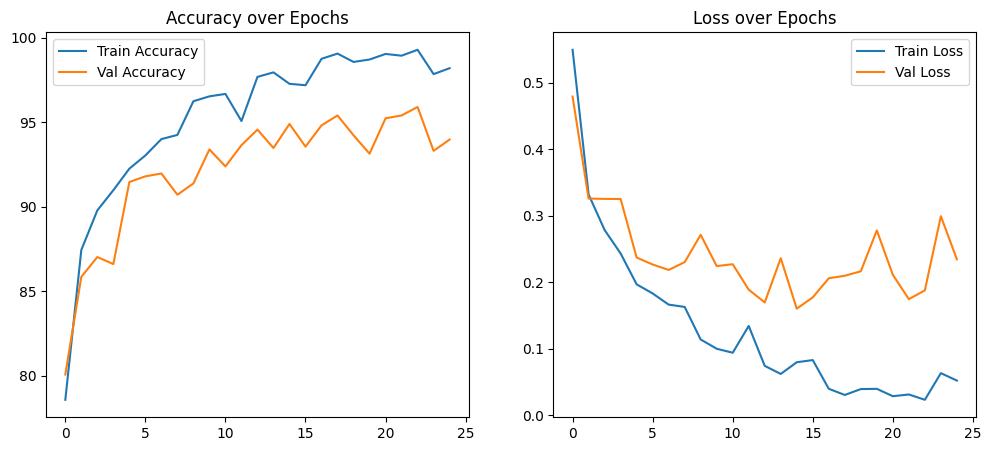

In [5]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# Testing

In [6]:
# Final Test Accuracy
model.eval()
test_correct, test_total = 0, 0
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        outputs = model(imgs)
        test_correct += (outputs.argmax(1) == lbls).sum().item()
        test_total += lbls.size(0)

print(f"Final Test Accuracy: {100 * test_correct / test_total:.2f}%")

Final Test Accuracy: 94.49%
